# Machine learning project -- Part 3  Improve ML models performance

This project is to build a predictive machine learning model using the customer churn data available at Kaggle website. <br>
Part 3 will look at building data pipelines that include engineering new features, training various classification models, and hyperparameter tuning selected candidate models.<br>

The classification algorithms to be considered:
1. KNN
2. logistic regression
3. Decision Trees 
4. SVM linear
5. SVM RBF
6. neural network (multi-layer perceptron)
7. Guassian process
8. Naive-Bayes (GaussianNB)
9. Quadratic Discriminant Analysis
10. Ensemble model (e.g., Random Forest, boosting algorithms) 


## Prepare data
### Global functions

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Read in data

In [2]:
## Read in data
df0 = pd.read_csv('./data/visathon_train_data.csv')#,index=customer_id)
print('Shape: {}'.format(df0.shape))
df0.sample(5)

Shape: (17654, 20)


,customer_id,vintage,age,gender,dependents,occupation,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
17084,23412.0,4767.0,78.0,Male,0.0,Lawyer,High,1336.0,4.0,6853.27,6729.84,6724.64,7136.06,123.47,0.04,0.04,0.04,6751.12,6729.84,Yes
14012,19196.0,1519.0,35.0,Male,0.0,Accountant,Medium,20.0,41.0,22675.78,22479.53,23048.75,25045.84,0.06,15.63,512.91,417.31,22608.42,22953.98,Yes
17344,23770.0,1563.0,45.0,Male,0.0,Accountant,Medium,239.0,3.0,51661.42,21657.92,26622.51,14133.05,37931.86,5524.07,3942.13,16.04,46741.13,18545.29,Yes
424,575.0,1215.0,76.0,Male,0.0,Lawyer,Low,2615.0,15.0,3368.08,2895.97,2969.17,2262.76,351.14,0.46,0.46,0.46,3276.19,2892.05,Yes
782,1086.0,1202.0,33.0,Female,0.0,Engineer,Low,2710.0,6.0,19286.39,0.66,2562.23,1101.39,40714.94,0.66,0.66,0.66,7685.39,0.66,Yes


### Group features

In [32]:
depend = ['dependents']
cat_vars = ['gender', 'occupation']#,'branch_code']

nw_cat = ['customer_nw_category']
bal_vars = ['current_balance', 'current_month_balance', 
            'previous_month_end_balance','previous_month_balance',
            'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2']
debit_vars = ['current_month_debit','previous_month_debit']
credit_vars = ['current_month_credit', 'previous_month_credit']
vin_age_vars = ['vintage', 'age']
vin_day_vars = ['days_since_last_transaction','vintage']
vin_dep_vars = ['dependents','vintage']

target = 'churn'

### Split data

In [4]:
X = df0.drop(target,axis=1).copy()
y = df0[target].copy()

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=10086)
print('X_train shape: {}\nX_test shape: {}\ny_train shape: {}\ny_test shape: {}'.format( X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train shape: (13240, 19)
X_test shape: (4414, 19)
y_train shape: (13240,)
y_test shape: (4414,)


## Create data pipelines
### Define custom functions
#### 1. Impute using BaseEstimator and TransformerMixin
These transformers have been tested, can be used in the pipelines to replace corresponding tranformers from custom functions in following section 2. They are not used in the pipeline for this project.

In [6]:
##################################################
from sklearn.base import BaseEstimator, TransformerMixin

## balance features
class AmongFeaturesMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, column=[], features=[]):
        """ column: feature to be imputed
            features: features to for average values (can include column)
        """
        self.features = features
        self.column = column

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        for feature in self.features:
            X[feature].fillna(X[self.features].mean(axis=1,skipna=True),inplace=True)
        return X

# debit and credit features
class FromFeatureImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features=[]):
        """ Column: feature to be imputed
            feature: feature to provide value
        """
        self.features = features
#         self.column = column

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        print(self.features)
        print([self.features[0]])
        print(self.features + [self.features[0]])
        feature_list = self.features + [self.features[0]]
        for i, feature in enumerate(feature_list):
            if i < len(feature_list)-1:
                X[feature] = X[feature].fillna(X[feature_list[i+1]]*(1+np.random.randn()))
        return X 

#### 2. Define custom functions
##### **1) Impute and log transform**

In [36]:
## combine non-frequent categories into one
def combine_cat(s, cutoff=6, replace=6):
    """ Replace the categories that are greater than or equal to the cutoff with replace
        s: a Pandas series
        cutoff: a scalar
        cat: scalar
        
        return: a series with replaced values
    """
    s_ = s.copy()
    mask = s > cutoff
    s_[mask==True] = replace
    return s_

# balance, debit, credit, days_since_last_transaction
def log_transform(df):
    """ Log transform the values in the df.
            for values < 0, log tranform absolute value, and then reverse to negative.
        df: a panda dataframe or array like.
        
        return: a pandas dataframe with log transformed values
    """
    df_ = pd.DataFrame(df.copy())
    s_= []
    for i in range(df.shape[1]):
        s_.append([np.log(x+1) if x>=0 else -np.log(-x+1) for x in df_.iloc[:,i]])
    s_ = pd.DataFrame.from_records(s_).transpose()
    return s_

## balance features
def impute_balance(df):
    """ Fill in missing values in each column with the average value of other columns in the same row
        df: a panda dataframe. To be imputed.
        
        return: a pandas dataframe without missing values
    """
    s_= []
    for i in range(df.shape[1]):
        s = df.iloc[:,i] 
        s_.append(s.fillna(df.mean(axis=1,skipna=True)))
    s_ = pd.DataFrame.from_records(s_).transpose()
    return s_

# debit and credit features
def impute_credit_debit(df):
    """ Fill in missing values in each column with the average value of other columns in the same row
            then add some randomness to the replacement value.
        df: a panda dataframe. To be imputed.
        
        return: a pandas dataframe without missing values
    """
    s_= []
    for i in range(df.shape[1]):
        s = df.iloc[:,i] 
        s_.append(s.fillna(df.mean(axis=1)*(1+np.random.randn())))
    s_ = pd.DataFrame.from_records(s_).transpose()
    return s_

##### **2) Engineer new features**

In [37]:
## Engineer new features 
# percentage changes
def calculate_pct_change(df):
    """ calculate percent changes in balance between consecutive periods
        df: Pandas dataframe or array. Balance columns of two consecutive peroids
        
        return: a dataframe containing percent changes with one less number of columns.
    """
    df_ = pd.DataFrame(df.copy())
    s_ = []
    for i in range(df_.shape[1]-1):
        s1 = df_.iloc[:,i]
        s2 = df_.iloc[:,i+1]
        s_.append((s1-s2)/(s2+1)*100) # s2+1 to avoid dividing-by-zero
    df_ = pd.DataFrame.from_records(s_).transpose()
    return df_ 

# vintage/(day_since_last_transaction) & per person values in a household
def calculate_ratio(df):
    """ calculate the ratio of two features. First column is denominator
        df: Pandas dataframe or numpy array.
        
        return: a dataframe containing ratio with one less number of columns.
    """
    s_ = []
    df_ = pd.DataFrame(df.copy())
    s1 = df_.iloc[:,0]
    for i in range(1,df_.shape[1]):
        s2 = df_.iloc[:,i]
        s_.append(s2/(s1+1)) #to avoid dividing by zero
    df_ = pd.DataFrame.from_records(s_).transpose()
    return df_ 

# vintage_age score 1 - equal distance
def calculate_vintage_age_score_eqdist(df):
    """ Calculate vintage-age combined score with equal-distance bins (pd.cut)
        df: an array of shape (*,2) or a dataframe
            df.shape[0]: for vintage column
            df.shape[1]: for age column
        
        return: a 2D array (shape (*,1)) withe the scores
    """
    # df = df[['vintage','age']]
    # Vintage
    df_ = pd.DataFrame(df.copy())
    mask = df_.iloc[:,0] >= 7000
    df_['vintage_score'] = df_.iloc[:,0]//1000 + 1
    df_['vintage_score'][mask] = 8
    
    # age
    cut_score = [1, 2, 3, 4, 5, 6, 7, 8]
    cut_bins = [0, 10, 19, 29, 39, 49, 59, 69, 100]
    df_['age_score'] = pd.cut(df_.iloc[:,1], bins=cut_bins, labels=cut_score).astype(int)
    df_['vintage_age_score'] = df_['vintage_score'] * df_['age_score']
    # return 2D arrage required
    return df_['vintage_age_score'].values.reshape(-1,1)

# vintage_age score 2 - equal population
def calculate_vintage_age_score_eqdens(df):
    """ Calculate vintage-age combined score with equal-population bins (pd.qcut)
        df: an array of shape (*,2) or a dataframe
            df.shape[0]: for vintage column
            df.shape[1]: for age column
        
        return: a 2D array (shape (*,1)) withe the scores
    """
    # df = df[['vintage','age']]
    df_ = pd.DataFrame(df.copy())
    cut_score = [1, 2, 3, 4, 5, 6, 7, 8]
    df_['vintage_score'] = pd.qcut(df_.iloc[:,0], q=8, labels=cut_score).astype(int)
    df_['age_score'] = pd.qcut(df_.iloc[:,1], q=8, labels=cut_score).astype(int)
    df_['vintage_age_score'] = df_['vintage_score'] * df_['age_score']
    # return 2D arrage required
    return df_['vintage_age_score'].values.reshape(-1,1)

### Make pipelines

In [38]:
# Original features
comb_cat_depend = FunctionTransformer(func=combine_cat, kw_args={'cutoff':6, 'replace':6}, validate=False)
log_tsfm = FunctionTransformer(func=log_transform)
impute_crdt_dbt = FunctionTransformer(func=impute_credit_debit)
impute_bal = FunctionTransformer(func=impute_balance)

# feature engineering
pct_tsfm = FunctionTransformer(func=calculate_pct_change)
ratio_tsfm = FunctionTransformer(func=calculate_ratio)
seniority_tsfm_dist = FunctionTransformer(func=calculate_vintage_age_score_eqdist)
seniority_tsfm_dens= FunctionTransformer(func=calculate_vintage_age_score_eqdens)

In [39]:
pipe_depend = Pipeline([('comb_depend',comb_cat_depend),
                        ('imput_depend',SimpleImputer(strategy='constant',fill_value=1000)),
                        ('ohe_depend',OneHotEncoder(handle_unknown='ignore',sparse=False))
                       ])
pipe_cat = Pipeline([('imput_cat',SimpleImputer(strategy='constant',fill_value='other')),
                     ('ohe_cat',OneHotEncoder(handle_unknown='ignore',sparse=False))])
# num_vars
pipe_vin_age = Pipeline([('imput_base',SimpleImputer(strategy='median')),
                      ('scal_base',StandardScaler()) ]) # vintage, age
pipe_days_br = Pipeline([('imput_days_br',SimpleImputer(strategy='median')),
                     ('log_days_br',log_tsfm),
#                      ('scal_days_br',StandardScaler())
                        ]) # days_since_last_transaction
pipe_bal = Pipeline([('imput_bal',impute_bal),#AmongFeaturesMeanImputer(features=bal_vars)),
                     ('log_bal',log_tsfm),
                     ('scal_bal',StandardScaler())
                    ])
pipe_credit = Pipeline([('imput_credit', impute_crdt_dbt), #AmongFeaturesMeanImputer(features=credit_vars)),
                     ('log_credit',log_tsfm),
                     ('scal_credit',StandardScaler())]) # credit columns
pipe_debit = Pipeline([('imput_debit',impute_crdt_dbt),
                     ('log_debit',log_tsfm),
                     ('scal_debit',StandardScaler())]) # debit columns
# feature engineering
pipe_pct = Pipeline([('imput_bal_pct', impute_bal), #AmongFeaturesMeanImputer(features=bal_vars)),
                     ('pct_chg',pct_tsfm),
                     ('log_bal_pct',log_tsfm),
                     ('scal_bal_pct',StandardScaler()) 
                    ]) # consecutive balance percent change
pipe_vin_days = Pipeline([('imput_vinday',SimpleImputer(strategy='median')),
                          ('ratio_vinday',ratio_tsfm), # df['days_since_last_transactio','vintage']
                          ('scal_vinday',StandardScaler())
                         ]) # vintage per days_since_last_transaction
pipe_bal_person = Pipeline([('imput_bal_pers', impute_bal), #AmongFeaturesMeanImputer(features=bal_vars)),
                            ('ratio_bal_pers',ratio_tsfm), # df['dependents',balance columns]
                            ('log_bal_pers',log_tsfm),
                            ('scal_bal_pers',StandardScaler()) 
                           ]) # balance per person
pipe_credit_person = Pipeline([('imput_credit_pers', impute_crdt_dbt), #AmongFeaturesMeanImputer(features=credit_vars)),
                               ('ratio_credit_pers',ratio_tsfm), # df['dependents',credit columns]
                               ('log_credit_pers',log_tsfm),
                               ('scal_credit_pers',StandardScaler())]) # credit per person
pipe_debit_person = Pipeline([('imput_debit',impute_crdt_dbt),
                              ('ratio_debit_pers',ratio_tsfm), # df['dependents', debit columns]
                              ('log_debit_pers',log_tsfm),
                              ('scal_debit_pers',StandardScaler())]) # debit per person
pipe_seniority = Pipeline([('imput_vinage',SimpleImputer(strategy='median')),                      
                           ('sr_tsfm', seniority_tsfm_dens),
                           ('scal_vinage',StandardScaler()) 
                          ]) # vintage, age]) 

In [40]:
nw_categories = [['Low','Medium','High']]
pipeline_data = ColumnTransformer([
            # categorical vars
           ('depend', pipe_depend, depend), # 7 cols
           ('cat_vars', pipe_cat, cat_vars), # 8 colc
           ('ode_nw', OrdinalEncoder(categories=nw_categories), nw_cat), # 1 col
           # numeric vars
           ('vin_age', pipe_vin_age, vin_age_vars), # 2 cols
           ('days_br', pipe_days_br, ['days_since_last_transaction','branch_code']), # 2 col
           ('num_bal', pipe_bal, bal_vars), # 6 cols
           ('num_debit', pipe_debit, debit_vars), # 2 cols
           ('num_credit', pipe_credit, credit_vars), # 2 cols
           # engineered features
           ('eng_pct', pipe_pct, bal_vars), # 5 cols
           ('eng_vinday', pipe_vin_days, vin_day_vars), # 1 cols
           ('eng_balpers', pipe_bal_person, depend+bal_vars), # 6 cols
           ('eng_crdpers', pipe_credit_person, depend+credit_vars), # 2 cols
           ('eng_dbtpers', pipe_debit_person, depend+debit_vars), # 2 cols
           ('eng_srscore', pipe_seniority, vin_age_vars) #[vintage, age] # 1 cols
  ]) #totla cols = 47

### Apply pipelines

In [42]:
pipeline_data.fit(X_train)
joblib.dump(pipeline_data, 'pipeline_data.joblib')
# pipeline_data = joblib.load('pipeline_data.joblib')

In [71]:
X_train_transformed = pipeline_data.transform(X_train)
X_test_transformed = pipeline_data.transform(X_test)
X_train_transformed.shape, X_test_transformed.shape

((13240, 47), (4414, 47))

Once the data sets are transformed, the next step is to use the transformed data to train models.

## Train classification models
This section we will look at screen various classification algorithms to select a few promising candidates for further tuning.

### Model set 1
This model set includes 9 scikit-learn classification algorithms (excluding those from ensemble family). The classification algorithms from the ensumble family will be discussed in ***Model set 2*** section.

#### 1. Select candidate models

In [50]:
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Model seclection
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

# Model evaluation
from sklearn.metrics import roc_auc_score, roc_curve

from time import time

In [18]:
names = [
    "K Nearest Neighbors",
    "Logistic Regression",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Neural Net",
    "Naive Bayes",
    "Quadratic Discriminant Analysis",
    "Gaussian Process",
]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(max_iter=500, n_jobs=-1, random_state=15611),
    SVC(kernel="linear", C=0.025, probability=True, random_state=15611),
    SVC(gamma=2, C=1, probability=True, random_state=15611),
    DecisionTreeClassifier(max_depth=5, random_state=15611),
    MLPClassifier(alpha=1, max_iter=1000, random_state=15611),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=15611),
]

In [19]:
# iterate over classifiers

score = {}
model = {}
for name, clf in zip(names, classifiers):
    start = time()   
    print("Fitting: {}".format(name))
    clf.fit(X_train_transformed, y_train)
    pred_proba = clf.predict_proba(X_test_transformed)
    roc_auc = roc_auc_score(y_test, pred_proba[:,1])
    score[name] = roc_auc
    model[name] = clf
    print("{} has a roc_auc score: {}".format(name, roc_auc))
    print(f'Time elapsed: {round((time()-start)/60,2)} minutes for model "{name}"\n')
    joblib.dump(clf, 'screening - ' + name +'.joblib')


Fitting: K Nearest Neighbors
K Nearest Neighbors has a roc_auc score: 0.6986985892675712
Time elapsed: 0.05 minutes for model "K Nearest Neighbors"

Fitting: Logistic Regression
Logistic Regression has a roc_auc score: 0.820827230786587
Time elapsed: 0.07 minutes for model "Logistic Regression"

Fitting: Linear SVM
Linear SVM has a roc_auc score: 0.8119037849267844
Time elapsed: 0.33 minutes for model "Linear SVM"

Fitting: RBF SVM
RBF SVM has a roc_auc score: 0.6937902614169622
Time elapsed: 2.21 minutes for model "RBF SVM"

Fitting: Decision Tree
Decision Tree has a roc_auc score: 0.7884593561234959
Time elapsed: 0.0 minutes for model "Decision Tree"

Fitting: Neural Net
Neural Net has a roc_auc score: 0.8367778819412206
Time elapsed: 0.11 minutes for model "Neural Net"

Fitting: Naive Bayes
Naive Bayes has a roc_auc score: 0.7619903603888725
Time elapsed: 0.0 minutes for model "Naive Bayes"

Fitting: Quadratic Discriminant Analysis
Quadratic Discriminant Analysis has a roc_auc score

C:\Users\tessi\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Gaussian Process has a roc_auc score: 0.8369046751415109
Time elapsed: 151.12 minutes for model "Gaussian Process"



In [30]:
screening_results = {'score':score,'model': model}
joblib.dump(screening_results, 'sccreening - results all models.joblib')

['sccreening - results all models.joblib']

The screening of the models indicated that 3 models, i.e., ***LogigsticRegression, Neural Network (MLPClassifier), and GaussianProcessClassifier)***, have ***over 0.82*** roc_auc scores. <br>
Since the GaussianProcessClassifier is already hyperparameter optimized for the kernel and none of the other parameters are to be tuned, we will use the result from this stage as the best estimator. <br>
Therefore, the next step is to further tune the remaining two models to select the best models and parameters for this dataset.

#### 2. Tune Hyperparameters of candiate models
We will tune the hyparameters using ***RandomSearchCV*** from scikit learn's model_selection module. Parameter distribution will be using the ***loguniform and randint*** distribution from scipy's stats module. Thes distributions generate a continuous range of floates and integers, repectively, for the hyperparameters of interest. We will use two sets of parameter spaces to tune the selected candidate models.

##### **Hyperparameter tuning version 1**
##### *1) Randomized Search CV*

In [101]:
## create a pipeline
pipe_clf = Pipeline([('classifier',LogisticRegression())])

## Create dictionary with candidate learning algorithms and their hyperparameters
param_space =  [{"classifier": [LogisticRegression(random_state=15611)],
                 'classifier__penalty': ['l1','l2'],
                 'classifier__solver': ['liblinear'],
                 'classifier__C': loguniform(0.0001, 100),
                 'classifier__max_iter': randint(200, 600),
                },
                {"classifier": [LogisticRegression(random_state=15611)],
                 'classifier__penalty': ['l2'],
                 'classifier__solver': ['lbfgs','sag'],
                 'classifier__C': loguniform(0.0001, 100),
                 'classifier__max_iter': randint(200, 600),
                },
                {"classifier": [MLPClassifier(random_state=15611)],
                 'classifier__activation':['tanh','relu'],
                 'classifier__hidden_layer_sizes': randint(5,100),
                 'classifier__learning_rate': ['constant','invscaling'],
                 'classifier__max_iter': randint(200,600),
                 'classifier__solver': ['adam','sgd'],
                 'classifier__alpha':loguniform(0.0001,1),
                },]

# Parameter tuning
start = time()
clf_randsearchcv_v1 = RandomizedSearchCV(estimator = pipe_clf, 
                                      param_distributions=param_space, 
                                      scoring='roc_auc',
                                      n_iter=100,
                                      cv=5, 
                                      verbose=1,
                                      n_jobs=-1
                                      )
clf_randsearchcv_v1.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round((time()-start)/60,2)} minutes')
# joblib.dump(clf_randsearchcv_v1,'clf_randsearchcv_v1.joblib')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.0min finished


Time elapsed: 10.13 minutes


In [ ]:
# load the save search result
# clf_randsearchcv_v1 = joblib.load('clf_randsearchcv_v1.joblib')

##### *2) Best estimator*

In [88]:
print(f'Best roc_auc Score: {round(clf_randsearchcv_v1.best_score_,4)}')
print('Best model and parameters:')
clf_randsearchcv_v1.best_params_

Best roc_auc Score: 0.8379
Best model and parameters:


{'classifier': MLPClassifier(activation='tanh', alpha=0.38935258508469467,
               hidden_layer_sizes=28, learning_rate='invscaling', max_iter=201,
               random_state=15611),
 'classifier__activation': 'tanh',
 'classifier__alpha': 0.38935258508469467,
 'classifier__hidden_layer_sizes': 28,
 'classifier__learning_rate': 'invscaling',
 'classifier__max_iter': 201,
 'classifier__solver': 'adam'}

In [159]:
# number of layers in the neural network:
print('Number of layers in the neural network = {}'.format(clf_randsearchcv_v1.best_estimator_['classifier'].n_layers_))

Number of layers in the neural network = 3


In [137]:
print(f"Mean cv scores - Highest: {clf_randsearchcv_v1.cv_results_['mean_test_score'].max()} \
from param combination {np.where(clf_randsearchcv_v1.cv_results_['mean_test_score'] == clf_randsearchcv_v1.cv_results_['mean_test_score'].max())[0]}")

print('Mean cv scores - each parameter and model combination:')
clf_randsearchcv_v1.cv_results_['mean_test_score']

Mean cv scores - Highest: 0.8379093513430848 from param combination [3]
Mean cv scores - each parameter and model combination:


array([0.82151629, 0.79684885, 0.81794237, 0.83790935, 0.82088359,
       0.82174965, 0.65494711, 0.83362775, 0.73170616, 0.81984577,
       0.83474748, 0.82129171, 0.82146317, 0.82064821, 0.75367458,
       0.73709169, 0.82191399, 0.82149625, 0.80168914, 0.83367901,
       0.82030039, 0.83663627, 0.77737538, 0.82194929, 0.82045501,
       0.8204836 , 0.80535238, 0.77609111, 0.82186502, 0.81848811,
       0.7699744 , 0.8207042 , 0.82135922, 0.79318678, 0.80418998,
       0.8203969 , 0.81810913, 0.82069966, 0.820655  , 0.48021626,
       0.82986912, 0.82145906, 0.82115763, 0.80329084, 0.61577944,
       0.82112491, 0.81357035, 0.83236597, 0.68214409, 0.67142501,
       0.81148789, 0.82088267, 0.83311285, 0.65881501, 0.82989067,
       0.81364233, 0.81809315, 0.81604758, 0.83502415, 0.82087179,
       0.83214886, 0.82193238, 0.8317863 , 0.54567031, 0.82170219,
       0.83106641, 0.83138798, 0.82138013, 0.79364219, 0.77980652,
       0.83355872, 0.82108719, 0.81368765, 0.83146683, 0.82142

##### *3) Best prediction accuracy*

In [89]:
# Best prediction score
clf_nn_v1_pred_proba = clf_randsearchcv_v1.best_estimator_.predict_proba(X_test_transformed)
clf_nn_v1_roc_auc = roc_auc_score(y_test, clf_nn_v1_pred_proba[:,1])
print(f'Prediction score with the best model: {round(clf_nn_v1_roc_auc,4)}')

Prediction score with the best model: 0.8394


##### **Hyperparameter tuning version 2**
##### *1) Random Search CV*

In [95]:
## create a pipeline
pipe_clf = Pipeline([('classifier',LogisticRegression())])

## Create dictionary with candidate learning algorithms and their hyperparameters
param_space =  [{"classifier": [LogisticRegression(random_state=15611, max_iter=200)],
                 'classifier__penalty': ['l1','l2'],
                 'classifier__solver': ['liblinear'],
                 'classifier__C': loguniform(0.0001, 100),
                },
                {"classifier": [LogisticRegression(random_state=15611, max_iter=200)],
                 'classifier__penalty': ['l2'],
                 'classifier__solver': ['lbfgs','sag'],
                 'classifier__C': loguniform(0.0001, 100),
                },
                {"classifier": [MLPClassifier(random_state=15611)],
                 'classifier__activation':['tanh','relu'],
                 'classifier__learning_rate': ['constant','invscaling'],
                 'classifier__solver': ['adam','sgd'],
                 'classifier__alpha':loguniform(0.0001,1),
                },]

# Parameter tuning
start = time()
clf_randsearchcv_v2 = RandomizedSearchCV(estimator = pipe_clf, 
                                      param_distributions=param_space, 
                                      scoring='roc_auc',
                                      n_iter=50,
                                      cv=5, 
                                      verbose=1,
                                      n_jobs=-1
                                      )
clf_randsearchcv_v2.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round((time()-start)/60,2)} minutes')


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.7min finished


Time elapsed: 4.9 minutes


In [47]:
# joblib.dump(clf_randsearchcv_v2,'clf_randsearchcv_v1.joblib')
clf_randsearchcv_v2 = joblib.load('clf_randsearchcv_v2.joblib')

##### *2) Best estimator*

In [85]:
print(f'Best SearchCV_v2 score: {clf_randsearchcv_v2.best_score_}')
clf_randsearchcv_v2.best_params_

Best SearchCV_v2 score: 0.839103115105563


{'classifier': MLPClassifier(activation='tanh', alpha=0.4478425726391438, random_state=15611),
 'classifier__activation': 'tanh',
 'classifier__alpha': 0.4478425726391438,
 'classifier__learning_rate': 'constant',
 'classifier__solver': 'adam'}

In [158]:
# number of layers in the neural network:
print('Number of layers in the neural network = {}'.format(clf_randsearchcv_v2.best_estimator_['classifier'].n_layers_))

Number of layers in the neural network = 3


In [140]:
print(f"Mean cv scores - Highest: {clf_randsearchcv_v2.cv_results_['mean_test_score'].max()} \
from param combination {np.where(clf_randsearchcv_v2.cv_results_['mean_test_score'] == clf_randsearchcv_v2.cv_results_['mean_test_score'].max())[0]}")

print('Mean cv scores:')
clf_randsearchcv_v2.cv_results_['mean_test_score']

Mean cv scores - Highest: 0.839103115105563 from param combination [41]
Mean cv scores:


array([0.66425661, 0.8209059 , 0.82913114, 0.82100155, 0.83592013,
       0.81586767, 0.83591262, 0.82087429, 0.81268031, 0.7919965 ,
       0.81123339, 0.82035047, 0.80174231, 0.82167036, 0.82176002,
       0.82179371, 0.68246772, 0.82122198, 0.82119354, 0.76509826,
       0.81389326, 0.82173856, 0.81001897, 0.82147313, 0.8211714 ,
       0.82164016, 0.83228349, 0.82096345, 0.82111813, 0.79507499,
       0.8058042 , 0.81480261, 0.83229064, 0.81800025, 0.82136718,
       0.48169423, 0.80310711, 0.81521753, 0.48021626, 0.8161643 ,
       0.69474344, 0.83910312, 0.77793357, 0.69476292, 0.80344506,
       0.82117406, 0.66424177, 0.80677766, 0.81221626, 0.79285558])

##### *3) Best prediction accuracy*

In [141]:
# Best prediction score
clf_nn_v2_pred_proba = clf_randsearchcv_v2.best_estimator_.predict_proba(X_test_transformed)
clf_nn_v2_roc_auc = roc_auc_score(y_test, clf_nn_v2_pred_proba[:,1])
clf_nn_v2_roc_auc

0.8392774717768654

### Model set 2
This model set includes 9 scikit-learn classification algorithms (excluding those from ensemble family). The classification algorithms from the ensumble family will be discussed in ***Model set 2*** section.

In [50]:
# Classifiers
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Model selection
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

# Model Evaluation
from sklearn.metrics import roc_auc_score, roc_curve

from time import time

## Learning curve
This section will plot the learning curve of the best models identified in the previous section from Model sets 1 and 2.

In [142]:
# download from GitHub repository
import requests
# Save plot_learning_curve as file to colab working directory
# Get the "Raw" version of the code from GitHub
url = 'https://raw.githubusercontent.com/TessieTong/ds4ml/main/plot_learning_curve.py'
r = requests.get(url)

# Write to Colab working directory 
with open('plot_learning_curve.py', 'w') as f:
    f.write(r.text)

# import
from plot_learning_curve import plot_learning_curve

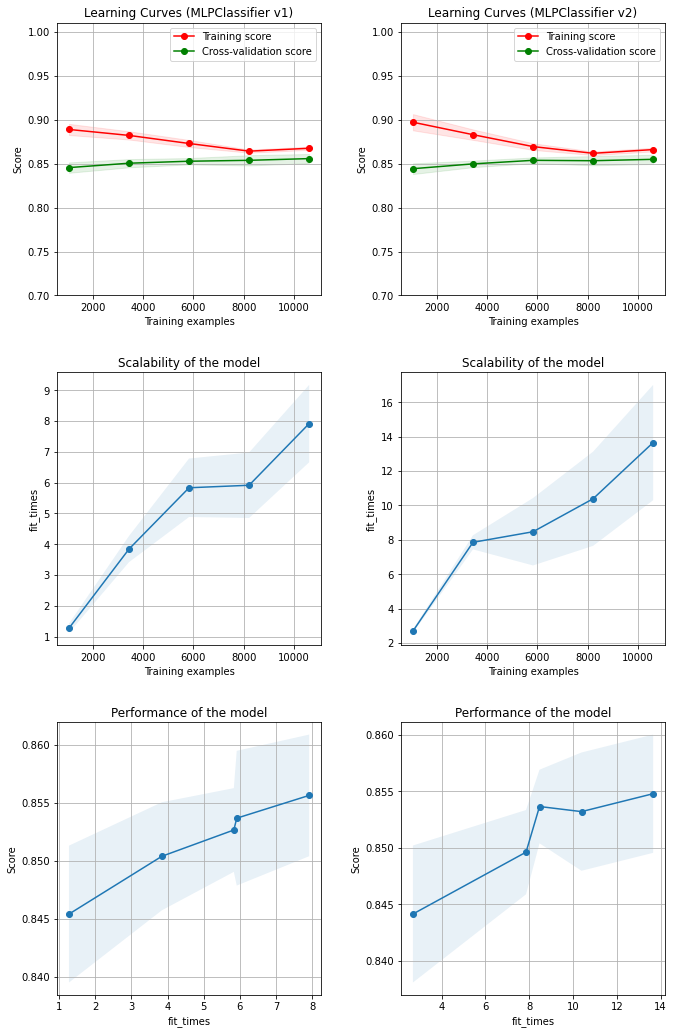

In [144]:
# Plot learning curves of the 4 best ensemble classifiers
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
nrows=3
ncols=2
fig, axes = plt.subplots(3, 2, figsize=(ncols*5, nrows*5))
# Cross validation with 10 iterations
# score curves, each time with 20% data randomly selected as a validation set.
# Here only the training set is used.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=15611)

title = r"Learning Curves (MLPClassifier v1)"
plot_learning_curve(clf_randsearchcv_v1.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (MLPClassifier v2)"
plot_learning_curve(clf_randsearchcv_v2.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

# title = r"Learning Curves (ExtraTree)"
# plot_learning_curve(xtr_rscv.best_estimator_,
#     title, X_train_transformed, y_train, 
#     axes=axes[:, 2], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

# title = r"Learning Curves (GradientBoosting)"
# plot_learning_curve(gbc_rscv.best_estimator_,
#     title, X_train_transformed, y_train, 
#     axes=axes[:, 3], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.tight_layout(pad=3.0)
plt.show();

Both models are somewhat underfitting, judging by the trend and relationship of training score and cross-validation score. Training score decreases relatively rapidly while cross-validation score clibmes slowly, with increasing the number of examples. Version 2 (v2) seems to have a better scalability, but take more fit-times to get the highest score.

## Best predictive model

In [68]:
# Best prediction score
clf_nn_v1_pred_proba = clf_randsearchcv_v1.best_estimator_.predict_proba(X_test_transformed)
clf_nn_v1_roc_auc = roc_auc_score(y_test, clf_nn_v1_pred_proba[:,1])
print(f'Best prediction score v1: {round(clf_nn_v1_roc_auc,4)}')
clf_nn_v2_pred_proba = clf_randsearchcv_v2.best_estimator_.predict_proba(X_test_transformed)
clf_nn_v2_roc_auc = roc_auc_score(y_test, clf_nn_v2_pred_proba[:,1])
print(f'Best prediction score v2: {round(clf_nn_v2_roc_auc,4)}')

Best prediction score v1: 0.8394
Best prediction score v2: 0.8392


In [69]:
clf_randsearchcv_v1.best_estimator_

Pipeline(steps=[('classifier',
                 MLPClassifier(activation='tanh', alpha=0.38935258508469467,
                               hidden_layer_sizes=28,
                               learning_rate='invscaling', max_iter=201,
                               random_state=15611))])

The ***best predictive model*** is the ***Multi_Layer Perceptron classifier*** from scikit learn's neural_network model, with ***"tanh"*** activation function, ***"invscaling"*** learning rate schedule, and L2 penalty regulization parameter ***alpha = 0.389***. 

## Save the best model

In [70]:
joblib.dump(clf_randsearchcv_v1.best_estimator_, 'Best churn classifier.joblib')

['Best churn classifier.joblib']